# Trabajo Final - Inteligencia Colectiva

## Recomendación de libros a usuarios

### Realizado por:
* Natalia Gonzalez
* Sergio Marin
* Denis A. Zuluaga

### Importamos las librerias requeridas

Utilizaremos en el programa librerías que nos permitiran cargar y limpiar los datos con el fin de tener la mejor calidad en la información. Igualmente trabajaremos con la librería [**SurPRISE**](http://surpriselib.com/) para realizar el proceso de recomendación que consta de los siguientes pasos:
1. Carga de datos para entrenamiento
2. Cálculo estadísticos de error
3. Ejecución de las predicciones
4. Generación de las recomendaciones

El estilo de recomendación que vamos a extraer con el proceso anterior se basa en la técnica de Filtrado Colaborativo (Segaran, 2007). Dado esto trabajaremos con los siguientes algorítmos de predicción (Ekstrand, Riedl, & Konstan, 2010) los cuales arrojaran recomendaciones de **5 Libros** para una muestra de **5 Usuarios**, teniendo en cuenta que para Neighborhood-Based se trabajará con dos algorítmos de similitud:
* Baseline Predictors
* Neighborhood Item-Base 
    - *Cosine Similarity*
    - *Pearson Correlation*
* Singular Value Decomposition (SVD)

Como valor agregado del trabajo se utilizará la librería [**Scikit-Learn**](http://scikit-learn.org/stable/) con la finalidad de implementar el algorítmo de clustering K-Means proporcionado por este paquete. La idea con esta implementación es realizar una recomendación de **5 Usuarios** a seguir (recomendación para solicitud de amistad o seguir en el sitio) para una muestra de **5 Usuarios** (los mismos indicados anteriormente).

**Referencias de las librerías:**
* [Numpy](http://www.numpy.org/)
* [Pandas](https://pandas.pydata.org)
* [Surprise](http://surpriselib.com/)
* [SciPy](https://www.scipy.org/)
* [Scikit-Learn](http://scikit-learn.org/stable/)
* [MatPlotLib](http://matplotlib.org/index.html)
* [Seaborn](http://seaborn.pydata.org/index.html)

In [1]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset
from surprise import BaselineOnly, KNNBasic, SVD
from surprise import evaluate

from collections import defaultdict
from random import randint

from scipy import stats, integrate
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

### Cargamos el archivo con las calificaciones

El archivo fuente representa un conjunto de usuarios de Amazon que realizaron calificaciones de libros en la página. Estas calificaciones están en un rango de 1 a 10. Dado que los datos fueron preparados por colaborados de [GroupLens](https://grouplens.org/datasets/book-crossing/) se entiende que están pre-procesados y por tanto, partimos del supuesto que son válidos.

Antes de comenzar a utilizar los datos, realizaremos un **proceso de depuración** con el fin de tener data limpia durante el proceso. Realizaremos un corte de los datos con base en los siguientes críterios:
* Eliminación de usuarios con edad mayor a 90 años
* Eliminación de ratings con calificación igual a 0
* Eliminación de ratings que tengan menos de 200 calificaciones por libro
* Eliminación de ratings que tengan menos de 3 calificaciones por usuario

In [2]:
# Carga base de datos de los usuarios.
df_users = pd.read_csv("Files/BX-Users.csv",
                   delimiter=";",
                   na_values="NA",
                   encoding="latin1")

# Eliminar los usuarios con edades mayores a 90. Hay un usuario que tiene 201 año, que está generando un cluster para él solo.
df_users = df_users[df_users['Age'] < 90]

print("Cantidad de usuarios cargados: ", df_users.index.size)

Cantidad de usuarios cargados:  167661


In [3]:
# Carga base de datos de los libros.
df_books = pd.read_csv("Files/BX-Books.csv",
                       delimiter=";",
                       na_values="NA",
                       encoding="latin1")

print("Cantidad de libros cargados: ", df_books.index.size)

Cantidad de libros cargados:  271379


In [4]:
# Carga base de datos de los ratings.
df_ratings = pd.read_csv("Files/BX-Book-Ratings.csv",
                        delimiter=";",
                        na_values="NA",
                        encoding="latin1")

# Se leen los registros con Rating > 0 que son los que tienen calificacion.
df_ratings= df_ratings[df_ratings['Book-Rating'] > 0]

# Realizamos una copia del conjunto de datos ratings y conservamos el original para otros calculos.
#datafile = df_ratings

# Realizamos un  agrupamiento por ISBN, para identificar los libros con mayor frecuencia en calificación
# y de esta manera depurar el conjunto de ratings, tomando datos muy significativos en calificación
df_books_group = pd.DataFrame(df_ratings.groupby(['ISBN']).size(), columns=['Count'])

# Seleccionamos libros con una frecuencia en calificación mayor que 200, para garantizar que hallan  
# varios usuarios calificando el mismo libro.
df_books_top = df_books_group[df_books_group['Count'] > 200]

# Realizamos el filtro de ratings aplicando regla de los libros top (> 200 calificaciones)
df_user_top_book = df_ratings.loc[df_ratings['ISBN'].isin(df_books_top.index)]
df_user_top_book.head()

# En el conjunto de datos anterior, que tiene el listado de los libros con mas de 200 calificaciones cada uno,
# identifico los lectores que asignaron mas de 3 calificaciones. El nuevo conjunto de datos tendrá los usuarios
# que calificaron más de 3 libros.
df_user_group = pd.DataFrame(df_user_top_book.groupby(['User-ID']).size(), columns=['Count'])
df_user_top = df_user_group[df_user_group['Count'] > 3]

# Realizamos el filtro de ratings aplicando regla de los usuarios top (> 3 calificaciones)
df_filtro_final = df_user_top_book.loc[df_user_top_book['User-ID'].isin(df_user_top.index)]

# Imprimimos totales del conjunto de datos ratings ya depurados
print("Cantidad de ratings cargados: ", df_filtro_final.index.size)
df_filtro_final.head(10)

Cantidad de ratings cargados:  1132


,User-ID,ISBN,Book-Rating
11551,805,0060928336,7
11561,805,0156027321,9
11575,805,0452282152,8
11580,805,0671003755,8
16697,2891,0060928336,6
16714,2891,0142001740,7
16715,2891,0156027321,5
16803,2891,0671003755,7
20801,4017,0316666343,10
20868,4017,0446310786,10


In [5]:
#Validación de registros duplicados
print("Cantidad de duplicados =", df_filtro_final.duplicated().sum())
#Validación cantidad de usuarios únicos
print("Cantidad de usuarios =", len(df_filtro_final['User-ID'].drop_duplicates()))
#Validación cantidad de libros únicos
print("Cantidad de libros =", len(df_filtro_final['ISBN'].drop_duplicates()))

Cantidad de duplicados = 0
Cantidad de usuarios = 218
Cantidad de libros = 29


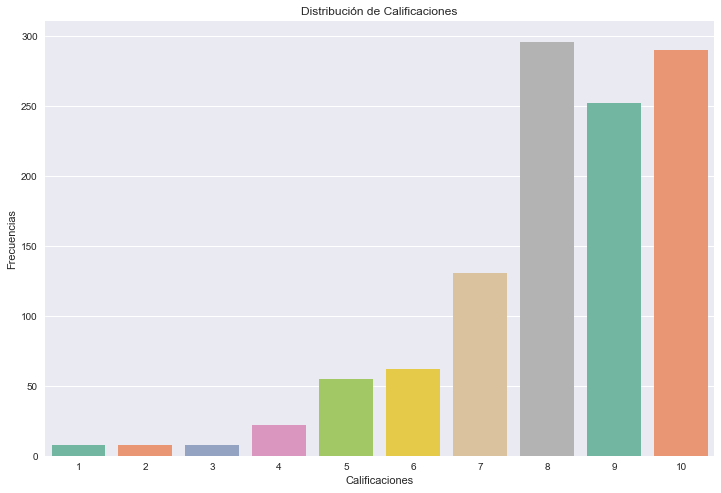

,Book-Rating,Count
0,1,8
1,2,8
2,3,8
3,4,22
4,5,55
5,6,62
6,7,131
7,8,296
8,9,252
9,10,290


In [6]:
#Validación cantidad de calificaciones
distratings = df_filtro_final.groupby(['Book-Rating']).count()["User-ID"].to_frame().reset_index(level=0, inplace=False)
distratings = distratings.rename(columns = {"User-ID":'Count'})

# Realizamos el gráfico de frecuencias por calificación
#plt.figure(figsize=(12, 8))
sns.set(rc={"figure.figsize": (12, 8)})
hst = sns.countplot(x="Book-Rating", data=df_filtro_final, palette="Set2")
plt.xlabel('Calificaciones')
plt.ylabel('Frecuencias')
plt.title('Distribución de Calificaciones')
plt.show()

#Imprimimos la tabla de datos con las cantidades de votos totales por tipo
distratings

In [7]:
#Estadisticos básicos del conjunto de datos
print("Estadísticos básicos de las calificaciones:")
df_filtro_final["Book-Rating"].describe()

Estadísticos básicos de las calificaciones:


count    1132.000000
mean        8.159011
std         1.756478
min         1.000000
25%         7.000000
50%         8.000000
75%        10.000000
max        10.000000
Name: Book-Rating, dtype: float64

### Procedimiento de recomendación

A continuación se realizaran cada uno de los pasos para realizar la predicción de las recomendaciones usando la librería **SurPRISE**. Es preciso recordar que serán utilizados los algorítmos de **filtrado colaborativo** mencionados anteriormente.


#### 1. Carga de datos para entrenamiento

En primera instancia se realiza la carga de los datos en el objeto **Reader** de Surprise utilizado para el mapeo de información de entrenamiento. Igualmente se realiza la creación del conjuto de datos en el objeto **Dataset** requerido por la librería para el manejo de la información, a partir de nuestro DataFrame inicial.

In [8]:
# Creación del reader con la escala de calificación únicamente
# ya que los datos se cargan desde un DataFrame.
reader = Reader(rating_scale=(1,10))

# Creación del conjuto de datos en el objeto Dataset.
# Se mapean los nombres de las columnas del archivo original
# tal como las tiene el DataFrame.
data = Dataset.load_from_df(df_filtro_final[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Para hacer la validación cruzada dividimos el conjunto de datos en diferentes particiones.
# Esto garantiza que el algoritmo de evaluación utiliza todas las particiones excepto una 
# para aplicar la validación a los datos donde se realiza el entrenamiento.
data.split(2)

# Optimización del algorítmo de entrenamiento
#param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
#grid_search = GridSearch(SVD, param_grid, measures=['RMSE', 'MAE'])
#grid_search.evaluate(data)
#results_df = pd.DataFrame.from_dict(grid_search.cv_results)
#print(results_df)

***NOTA 1:*** Los pasos del procedimiento de recomendación subsiguientes se deben repetir para cada uno de los algorítmos de predicción que serán trabajados: *BaselineOnly, KNN Item-Base, SVD (nombres de algorítmos según [docs](http://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html) de SurPRISE)*.

***NOTA 2:*** Para las predicción con el algorítmo de Neighborhood (KNN) solo se tomará en cuenta el filtrado **Item-Base** (basado en elementos), para nuestro caso sería "Basado en Libros". Esto dado que el filtrado Item-Base es significativamente **más rápido** que el User-Base al momento de recuperar una lista de recomendaciones en un conjunto de datos grande. Además, el filtrado Item-Base por lo general supera al filtrado User-Base cuando el conjunto de datos es **"disperso"**, sin embargo, se comportan de manera similar en conjuntos de datos **"densos"**. (Segaran, 2007)

#### 2. Cálculo estadísticos de error

El algoritmo intentará predecir la calificación de una combinación **Usuario/Libro** y comparará esa predicción con la predicción real. La diferencia entre la calificación real y la predicha se mide utilizando medidas de error clásicas como Root mean squared error ([RMSE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)) y Mean absolute error ([MAE](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)). Dichas mediciones será utilizadas en el proceso de evaluación de los algorítmos de predicción. A continuación se realizan los procesos de **evaluación** para todos los algorítmos definidos.

In [9]:
#Evaluación algoritmo Baseline Predictors (BaselineOnly)
algoBO = BaselineOnly()
evaluateBO = evaluate(algoBO, data, measures=['RMSE', 'MAE'])

#Evaluación algoritmo Neighborhood Item-Base con Cosine Similarity (KNNBasic)
sim_options = {'name': 'cosine', 'user_based': False}
algoKNNc = KNNBasic(sim_options=sim_options)
evaluateKNNc = evaluate(algoKNNc, data, measures=['RMSE', 'MAE'])

#Evaluación algoritmo Neighborhood Item-Base con Pearson Correlation (KNNBasic)
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algoKNNp = KNNBasic(sim_options=sim_options)
evaluateKNNp = evaluate(algoKNNp, data, measures=['RMSE', 'MAE'])

#Evaluación algoritmo Singular Value Decomposition (SVD)
algoSVD = SVD()
evaluateSVD = evaluate(algoSVD, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
RMSE: 1.5850
MAE:  1.1921
------------
Fold 2
Estimating biases using als...
RMSE: 1.5966
MAE:  1.2245
------------
------------
Mean RMSE: 1.5908
Mean MAE : 1.2083
------------
------------
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.8426
MAE:  1.3076
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.9615
MAE:  1.4100
------------
------------
Mean RMSE: 1.9020
Mean MAE : 1.3588
------------
------------
Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.8175
MAE:  1.2910
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing simila

In [10]:
# Formateo de las métricas de error para impresión en dataframe.
ma_eval_result = np.matrix([
    ['RMSE', np.mean(evaluateBO['RMSE']), np.mean(evaluateKNNc['RMSE']), np.mean(evaluateKNNp['RMSE']), np.mean(evaluateSVD['RMSE'])],
    ['MAE', np.mean(evaluateBO['MAE']), np.mean(evaluateKNNc['MAE']), np.mean(evaluateKNNp['MAE']), np.mean(evaluateSVD['MAE'])]
])
df_eval_result = pd.DataFrame(ma_eval_result, columns=['Metric','BaselineOnly','KNNCosine','KNNPearson','SVD'])
df_eval_result

,Metric,BaselineOnly,KNNCosine,KNNPearson,SVD
0,RMSE,1.59078622908,1.90201891166,1.86761961554,1.58492126996
1,MAE,1.2083364153,1.35877648408,1.33803226282,1.20610250304


Antes de continuar con el proceso de predicción realizaremos la **selección del mejor algorítmo** con base en las métricas de error calculadas en el paso anterior. El procedimiento de selección consiste en sumar el valor de **RSME** y **MAE** de cada algorítmo, luego se eleva al cuadrado y finalmente se identifica el menor valor.

In [11]:
df_eval_result['BaselineOnly'] = pd.to_numeric(df_eval_result['BaselineOnly'], errors='coerce').fillna(0)
df_eval_result['KNNCosine'] = pd.to_numeric(df_eval_result['KNNCosine'], errors='coerce').fillna(0)
df_eval_result['KNNPearson'] = pd.to_numeric(df_eval_result['KNNPearson'], errors='coerce').fillna(0)
df_eval_result['SVD'] = pd.to_numeric(df_eval_result['SVD'], errors='coerce').fillna(0)

# Calculamos la media entre las medidas RMSE y MAE de cada algorítmo y elevamos al cuadrado.
bo = df_eval_result['BaselineOnly'].mean()**2
knnc = df_eval_result['KNNCosine'].mean()**2
knnp = df_eval_result['KNNPearson'].mean()**2
svd = df_eval_result['SVD'].mean()**2

alg_means = [bo, knnc, knnp, svd]
min_value = min(alg_means)
select_algorit = -1

# Seleccionamos el indice del algorítmo con mejores resultados en la estimación.
# Los indices de los algorítmos son:
#    0 : BaselineOnly
#    1 : KNNCosine
#    2 : KNNPearson
#    3 : SVD
for index in range(len(alg_means)):
    if(min_value == alg_means[index]):
        select_algorit = index
        break

print("Algorítmo seleccionado para recomendar: ", select_algorit)

Algorítmo seleccionado para recomendar:  3


In [12]:
#### DEPRECATED INITIAL ####

# Finalmente se realiza el cálculo de las predicciones para un
# conjunto de prueba seleccionado por la librería
#df_predict_group = df_predict_book.groupby(['User-ID','ISBN'])
#df_predict_means = df_predict_group.agg({
#    'Book-Rating': 'mean',
#    'BaselineOnly': 'mean',
#    'KNNCosine': 'mean',
#    'KNNPearson': 'mean',
#    'SVD': 'mean'
#})

#Realizamos las diferencias del real por el estimado de cada algorítmo
#br_means = df_predict_means['Book-Rating'].values
#di_means = [
#    (np.abs(br_means - df_predict_means['BaselineOnly'].values)**2).sum(),
#    (np.abs(br_means - df_predict_means['KNNCosine'].values)**2).sum(),
#    (np.abs(br_means - df_predict_means['KNNPearson'].values)**2).sum(),
#    (np.abs(br_means - df_predict_means['SVD'].values)**2).sum()
#]
#min_value = min(di_means)

# Seleccionamos el indice del algorítmo con mejores resultados en la estimación
# Los indices de los algorítmos son:
#    0 : BaselineOnly
#    1 : KNNCosine
#    2 : KNNPearson
#    3 : SVD
#select_algorit = -1
#for index in range(len(di_means)):
#    if(min_value == di_means[index]):
#        select_algorit = index
#        break

#### DEPRECATED FINAL ####

#### 3. Ejecución de las predicciones

A continuación se realizará el pronóstico para una determinada muestra de usuarios quienes serán objeto de las predicciones del tipo **Usuario: Libros** (serán en total *5 usuarios* y se recomendarán *5 libros*), con esto podremos saber si al usuario le gustará un determinado libro o no. Para realizar las predicciones primero se ejecutan las funciones de "entrenamiento", ya que los algorítmos ejecutarán en total 2 corridas de la predicción (dado el split del conjunto de datos, que lo parte en tres grupos de datos).

In [13]:
# Realizamos el entrenamiento de todos los algorítmos.

# Entrenamiento Baseline Predictors (BaselineOnly)
trainset = data.build_full_trainset()
algoBO.train(trainset)

# Entrenamiento Neighborhood Item-Base con Cosine Similarity (KNNBasic)
trainset = data.build_full_trainset()
algoKNNc.train(trainset)

# Entrenamiento Neighborhood Item-Base con Pearson Correlation (KNNBasic)
trainset = data.build_full_trainset()
algoKNNp.train(trainset)

# Entrenamiento Singular Value Decomposition (SVD)
trainset = data.build_full_trainset()
algoSVD.train(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


#### Análisis y comparación de predictores

Antes de continuar adelante con el proceso de pronóstico y recomendación, se realizará la predicción de 5 usuarios con calificiaciones estimadas en un solo libro, seleccionado manualmente, y que dichos usuarios tengan calificado, con el fin de comparar predicción vs calificación real.

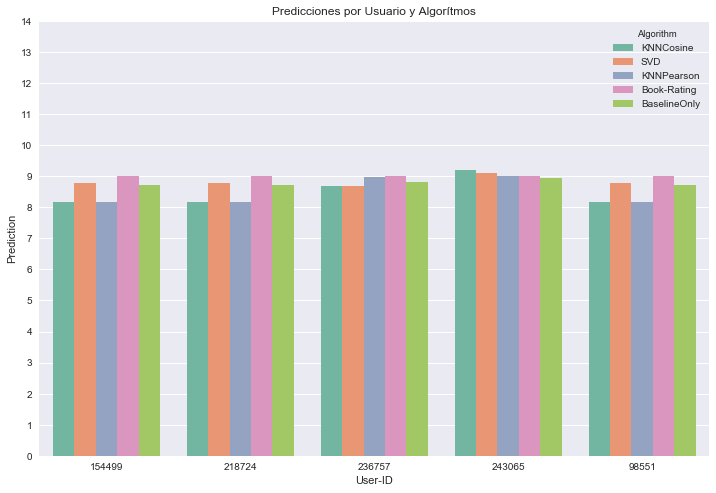

,User-ID,ISBN,Book-Rating,BaselineOnly,KNNCosine,KNNPearson,SVD
0,218724,0312195516,9,8.721806,8.159011,8.159011,8.790925
1,243065,0312195516,9,8.932465,9.194838,9.023398,9.119274
2,98551,0312195516,9,8.721806,8.159011,8.159011,8.790925
3,236757,0312195516,9,8.802779,8.669735,8.980632,8.672256
4,154499,0312195516,9,8.721806,8.159011,8.159011,8.790925


In [14]:
# Seleccionamos un libro y una muestra de 5 usuarios para comparar pronosticos
#x = df_filtro_final.groupby('ISBN').count()['User-ID'].to_frame().reset_index(level=0, inplace=False)
#x = x.rename(columns = {"User-ID":'Count'})
#itemid = x.sort_values('Count', ascending=False).iloc[1]['ISBN']
#y = datafile[datafile['ISBN'] == itemid]
#n = [randint(i, y.index.size-1) for i in range(5)]
#usersid = list(y.iloc[n]['User-ID'])
#ratings = list(y.iloc[n]['Book-Rating'])

itemid = '0312195516'
usersid = [218724,243065,98551,236757,154499]
ratings = [9,9,9,9,9]

ma_predict_book = []
for i in range(len(usersid)):
    bo = algoBO.predict(usersid[i], itemid, ratings[i])
    knnc = algoKNNc.predict(usersid[i], itemid, ratings[i])
    knnp = algoKNNp.predict(usersid[i], itemid, ratings[i])
    svd = algoSVD.predict(usersid[i], itemid, ratings[i])
    ma_predict_book.append([bo[0], bo[1], bo[2], bo[3], knnc[3], knnp[3], svd[3]])

df_predict_book = pd.DataFrame(np.matrix(ma_predict_book), 
                               columns=['User-ID','ISBN','Book-Rating','BaselineOnly','KNNCosine','KNNPearson','SVD'])

#Convierte las columnas de metrica en valores numericos
df_predict_book['Book-Rating'] = pd.to_numeric(df_predict_book['Book-Rating'], errors='coerce').fillna(0)
df_predict_book['BaselineOnly'] = pd.to_numeric(df_predict_book['BaselineOnly'], errors='coerce').fillna(0)
df_predict_book['KNNCosine'] = pd.to_numeric(df_predict_book['KNNCosine'], errors='coerce').fillna(0)
df_predict_book['KNNPearson'] = pd.to_numeric(df_predict_book['KNNPearson'], errors='coerce').fillna(0)
df_predict_book['SVD'] = pd.to_numeric(df_predict_book['SVD'], errors='coerce').fillna(0)

# Graficamos para cada usuario las calificaciones por cada algoritmo para comparar
df_predict_book2 = pd.melt(df_predict_book, 
                           id_vars=["User-ID", "ISBN"],
                           var_name="Algorithm", 
                           value_name="Prediction")
df_predict_book2 = df_predict_book2.sort_values(['Prediction'], ascending=False)

sns.set(rc={"figure.figsize": (12, 8)})
bar = sns.barplot(hue="Algorithm", y="Prediction", x="User-ID", data=df_predict_book2, palette="Set2")
plt.title('Predicciones por Usuario y Algorítmos')
plt.yticks(np.arange(15))
plt.show()

# Imprimimos la tabla de datos resultande de la predicción para análisis
df_predict_book

A continuación se realizará la ejecución de las **predicciones** para la población general. Para las recomendaciones de libros no tendremos en cuenta predicciones de todos los algorítmos, por tanto nos basaremos en el algorítmo seleccionado luego del cálculo de las métricas de error.

In [15]:
# Creamos el conjunto de pruebas para realizar la predicción.
testset = trainset.build_anti_testset()
predictions = None

# Ejecutamos la predicción correspondiente según cual sea la mejor estimación.
if(select_algorit == 0): predictions = algoBO.test(testset)
elif(select_algorit == 1): predictions = algoKNNc.test(testset)
elif(select_algorit == 2): predictions = algoKNNp.test(testset)
elif(select_algorit == 3): predictions = algoSVD.test(testset)

####  4. Generación de las recomendaciones

Finalizado el proceso de predicción, pasamos a la etapa de las **recomendaciones de libros a los usuarios**. En este caso tenemos una muestra al azar de 5 usuarios para los cuales se realizará la recomendación. Estos usuarios son diferentes a los procesados anteriormente, con el fin de que el sistema lance recomendaciones diferentes de libros. El programa generará una tabla con la siguiente información: *ID de usuario, ISBN Libro 1, ISBN Libro 2, ISBN Libro 3, ISBN Libro 4, ISBN Libro 5.*

In [16]:
# Función requerida para la extracción del top 5 de recomendaciones de libros a usuarios
# Fuente: https://github.com/NicolasHug/Surprise/issues/40
def get_top_n(predictions, users=[], nitems=5):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if(uid in users):
            top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        if(uid in users):
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:nitems]

    return top_n

# Listado de 5 usuarios al azar para los cuales se realizará la recomendación
users = [249628,91103,229313,81492,36907]
nitems = 5
#for i in range(nitems):
#    num = randint(0, len(testset)-1)
#    usr = testset[num][0]
#    users.append(usr)

# Extracción de las recomendaciones de los usuarios indicados
top_n = get_top_n(predictions, users=users, nitems=nitems)

# Obtenemos las recomendaciones seleccionadas
ma_predict_final = []
lb_predict_final = []
for uid, user_ratings in top_n.items():
    items = [iid for (iid, _) in user_ratings]
    for i in range(nitems - len(items)):
        items = items + [np.nan]
    ma_predict_final.append([uid] + items)
    
lb_predict_final.append('User-ID')
lb_predict_final = lb_predict_final + [('ISBN-'+str(i+1)) for i in range(len(ma_predict_final[0])-1)]
df_predict_final = pd.DataFrame(np.matrix(ma_predict_final), columns=lb_predict_final)
df_predict_final

,User-ID,ISBN-1,ISBN-2,ISBN-3,ISBN-4,ISBN-5
0,249628,043935806X,0446310786,0679781587,0312195516,0385504209
1,229313,0446310786,043935806X,0679781587,0316769487,0142001740
2,91103,0312195516,0446310786,043935806X,059035342X,0385504209
3,36907,043935806X,0446310786,0312195516,0679781587,059035342X
4,81492,0446310786,043935806X,0679781587,0312195516,0142001740


### Recomendaciones utilizando Machine Learning

En el siguiente apartado realizaremos el proceso de predicción y posterior **recomendación de usuarios**. La idea central es identificar un usuario que haya sido recomendado en las predicciones de libros e identificar para este un conjunto de usuarios a quienes puede seguir o suscribirse dada la afinidad o cercanía de su comportamiento en el sitio.

La técnica de Machine Learning que se implementará será una **clasificación de usuarios** por preferencias de libros y edad, utilizando el algorítmo de K-Means que se encuentra disponible en la librería *Scikit-Learn*.

#### 1. Preparación de los datos para clustering

Inicialmente se preparan los datos de calificaciones para realizar la ejecución del algorítmo de **K-Means**. Es preciso que los datos tengan como indice los códigos de usuarios y en cada columna los ISBN de los libros. En los valores de las celdas deben quedar las calificaciones de cada usuario a cada libro, considerando que algunas celdas quedaran vacías.

In [17]:
# Pivoteamos la tabla original para dejar el listado de Libros como variables con las que vamos a hacer el cluster.
df_pivot_rating = pd.pivot_table(df_filtro_final, index='User-ID', columns="ISBN", values="Book-Rating", aggfunc='mean')

# Reemplazar los valores nulos (NaN) por 0, dado que el algoritmo de cluster no admite celdas nulas.
# Representan que el usuario no ha leido el libro
df_pivot_rating = df_pivot_rating.fillna(0)

# Extraemos las edades de los usuarios para agregarlas al conjunto de datos para clustering.
df_users_1 = df_users.set_index("User-ID")
df_users_2 = df_users_1[['Age']]

# Normalizamos el valor de la edad a la escala de valores de las calificaciones.
df_users_2['Age'] = round(df_users_2[['Age']].sum(axis=1).apply(np.sqrt), 0)

# Realizar un Merge del conjunto con edades y el conjuto pivoteado, para agregar la edad al conjunto.
df_merge_2 = df_users_2.merge(df_pivot_rating, left_index=True, right_index=True)

print("Cantidad de usuarios para agrupamiento: ", df_merge_2.index.size)
df_merge_2.head(10)

Cantidad de usuarios para agrupamiento:  159


C:\Users\denizuqu\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,Age,0060928336,0060930535,0142001740,0156027321,0312195516,0312278586,0316601950,0316666343,0316769487,...,0452282152,059035342X,0671003755,0671021001,0671027360,067976402X,0679781587,0743418174,0786868716,0971880107
User-ID,,,,,,,,,,,,,,,,,,,,,
805,6.0,7.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,9.0,0.0,0.0,0.0
6563,6.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,...,0.0,8.0,0.0,2.0,0.0,0.0,0.0,9.0,10.0,0.0
7125,5.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,10.0,0.0
7283,5.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
8245,6.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8253,5.0,10.0,10.0,0.0,0.0,0.0,0.0,9.0,10.0,0.0,...,0.0,0.0,0.0,10.0,0.0,10.0,10.0,0.0,0.0,0.0
10560,5.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,8.0,0.0,...,0.0,10.0,0.0,0.0,8.0,0.0,0.0,8.0,0.0,0.0
15602,5.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0


#### 2. Ejecución del algorítmo de clustering

A continuación se configura y ejecuta el algorítmo de clustering que provee la librería **Scikit-Learn**, con el fin de agrupar los usuarios dadas las preferencias de libros y su edad. Esta clasificación tendrá como objetivo seleccionar la lista de usuarios que se recomendarán al usuario, ya sea para seguirlos o suscribirse a sus canales o simplemente para tenerlos como referentes en el sitio.

In [18]:
# Utilizamos la librería scikit-learn para crear un cluster de usuarios de acuerdo a su comportamiento
# calificando libros y la edad de los mismos

# Para el ejercicio utilizaremos 10 grupos:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(df_merge_2)
y_kmeans = kmeans.predict(df_merge_2)

# Imprimimos el conjunto de grupos por usuario, clusters:
print("Listado de clusters por usuario:\n\n", y_kmeans)

print()

## Imprimimos una de los centroides para fines informativos, centro de cada cluster:
print("Listado de valores primer centroide:\n\n", kmeans.cluster_centers_[0])

Listado de clusters por usuario:

 [4 6 2 2 3 4 6 3 6 2 7 1 0 2 7 6 4 5 2 8 2 8 2 2 8 2 8 4 6 9 8 3 5 2 7 7 5
 6 1 8 4 5 4 3 3 6 0 9 6 9 5 6 1 4 1 6 8 0 8 1 4 2 6 6 5 5 9 0 5 4 0 8 8 0
 6 8 3 8 8 5 2 2 1 5 5 2 8 6 8 3 6 5 1 8 3 5 3 8 5 2 0 2 8 6 2 1 3 0 5 3 9
 2 7 0 0 6 2 2 6 3 3 3 8 2 8 5 9 3 8 1 2 3 1 3 7 3 0 2 0 8 1 9 2 6 2 2 5 6
 8 5 4 0 4 2 3 5 5 3 1]

Listado de valores primer centroide:

 [  5.69230769e+00   3.84615385e+00   4.38461538e+00   4.61538462e-01
  -1.11022302e-16   7.84615385e+00   1.30769231e+00   5.38461538e-01
   6.15384615e-01   2.76923077e+00   2.69230769e+00   0.00000000e+00
   3.07692308e-01   7.69230769e-01   0.00000000e+00  -2.22044605e-16
   6.92307692e-01   0.00000000e+00  -1.11022302e-16   1.61538462e+00
   4.23076923e+00   7.69230769e-01   7.69230769e-01   6.15384615e-01
  -2.22044605e-16   0.00000000e+00   7.76923077e+00   1.38461538e+00
   7.69230769e-01   2.30769231e-01]


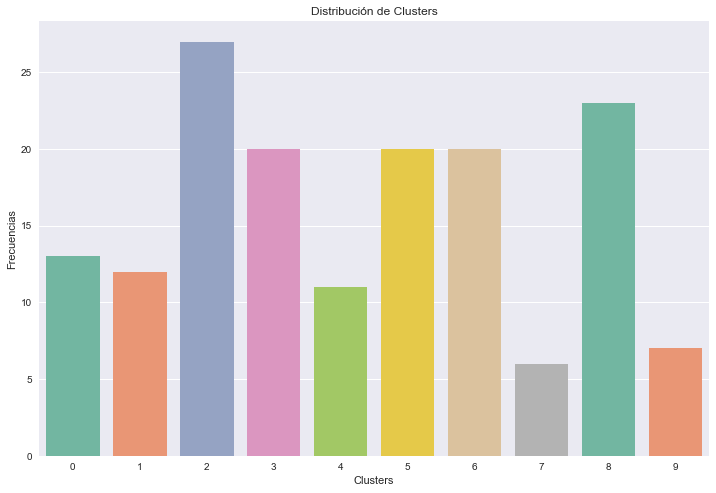

In [19]:
# Asignar el valor de cluster a cada usuario.
df_merge_2['Cluster'] = kmeans.labels_

# Imprimimos los usuarios con su respectivo cluster el cuál está en la última columna
#print("Listado de 10 usuarios con su cluster:")
#df_merge_2[['Age','Cluster']].head(10)

#Validación cantidad de clusters
distcluster = df_merge_2.groupby(['Cluster']).count()["Age"].to_frame().reset_index(level=0, inplace=False)
distcluster = distcluster.rename(columns = {"Age":'Count'})

# Realizamos el gráfico de frecuencias por cluster
sns.set(rc={"figure.figsize": (12, 8)})
hst = sns.countplot(x="Cluster", data=df_merge_2, palette="Set2")
plt.xlabel('Clusters')
plt.ylabel('Frecuencias')
plt.title('Distribución de Clusters')
plt.show()

### Recomendaciones de libros y usuarios

Finalmente, tenemos un conjunto de recomendaciones que podemos presentar a un usuario particular como parte del valor agregado que genera el sitio. A continuación realizaremos la selección de un usuario a partir de las predicciones de libros realizadas en la primera sección y se mostrará el top 5 de libros recomendados, así como la lista de usuarios que puede seguir o suscribirse.

In [26]:
# Seleccionamos el primer usuario de la lista de los 5 recomendados en la sección anterior.
record = df_predict_final.iloc[0]
user_id = int(record['User-ID'])
items_recom = [record[('ISBN-'+str(i))] for i in range(1,6)]

# Seleccionamos el número de cluster y ubicamos los usuarios recomendados.
num_cluster = df_merge_2[df_merge_2.index == user_id]['Cluster'].values[0]
users_recom = list(df_merge_2[df_merge_2['Cluster'] == num_cluster].index)
print("Número de cluster: ", num_cluster)

# Imprimo la información del usuario a quien voy a recomendar libros y otros usuarios.
df_users[df_users['User-ID'] == user_id]

Número de cluster:  8


,User-ID,Location,Age
249627,249628,"whitney, texas, usa",51.0


In [21]:
# Busco una muestra de los libros mejor calificados por el usuario
# para validar si en genero o tipo se parecen con las recomendaciones (validación visual)
user_ratings = df_ratings[df_ratings['User-ID'] == user_id].sort_values('Book-Rating', ascending=False)
user_books = list(user_ratings.iloc[:5]['ISBN'].values)

df_user_books = df_books[df_books['ISBN'].isin(user_books)][['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher']]
df_user_books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
211,0375705856,Plainsong (Vintage Contemporaries),KENT HARUF,2000,Vintage
6336,0020418809,CADDIE WOODLAWN,Carol Ryrie Brink,1970,Simon Pulse
23112,0912238259,Manna: foods of the frontier,Gertrude Harris,1972,"101 Productions; [distributed by Scribner, New..."
115178,0879055944,Maverick Western Verse,John C. Dofflemyer,1994,Gibbs Smith
116885,1555138128,Noah's Ark and Other Old Testament Stories,Chariot Family Publishing,1989,Cook Communications Ministries intl


#### Lecturas que quizás te gusten (libros recomendados por el algorítmo)

In [22]:
df_books_recom = df_books[df_books['ISBN'].isin(items_recom)][['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher','Image-URL-M']]

# Recomendación de 5 libros.
df_books_recom[['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher']]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
37,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown Company
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic


In [23]:
import urllib.request

# Descargamos las imagenes de los libros para tener la información en la presentación.
for index, row in df_books_recom.iterrows():
    urllib.request.urlretrieve(row['Image-URL-M'], "Images/"+row['ISBN']+".jpg")

#### Usuarios a quienes puedes seguir (usuarios recomendados por machine learning)

In [24]:
# Recomendación de 5 usuarios a quien seguir.
df_users[df_users['User-ID'].isin(users_recom)].head(5)

,User-ID,Location,Age
31555,31556,"chula vista, california, usa",51.0
36002,36003,"shah alam, selangor, malaysia",26.0
37711,37712,"cincinnati, ohio, usa",23.0
43245,43246,"toronto, ontario, canada",36.0
55186,55187,"torrance, california, usa",48.0


In [25]:
# Elegimos el primer usuario recomendado para seguir y buscaremos los libros
# que ha calificado y que también son libros calificados por el usuario en estudio
user_ref = df_users[df_users['User-ID'].isin(users_recom)].iloc[0]['User-ID']
user_ref_ratings = df_ratings[df_ratings['User-ID'] == user_ref]
user_ref_books = list(user_ref_ratings[user_ref_ratings['ISBN'].isin(items_recom)].iloc[:5]['ISBN'].values)

df_books[df_books['ISBN'].isin(user_ref_books)][['ISBN','Book-Title','Book-Author','Year-Of-Publication','Publisher']]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
37,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown Company


### Bibliografía

* Segaran, T. (2007). Programming Collective Intelligence. O'Reilly.
* Ekstrand, M. D., Riedl, J., & Konstan, J. (2010). Collaborative Filtering Recommender Systems. Foundations and Trends.